# Distribution B - Maximum Likelihood

In [71]:
import DistBTrunc as dbt
import DistExampB as db

import cvxpy as cp

from math import ceil, floor, log, sqrt
from matplotlib import pyplot as plot
from numpy import sinc
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from sympy import Symbol, lambdify

from LocMath import Bisect
from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import InterpZ

In [72]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

In [73]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 721


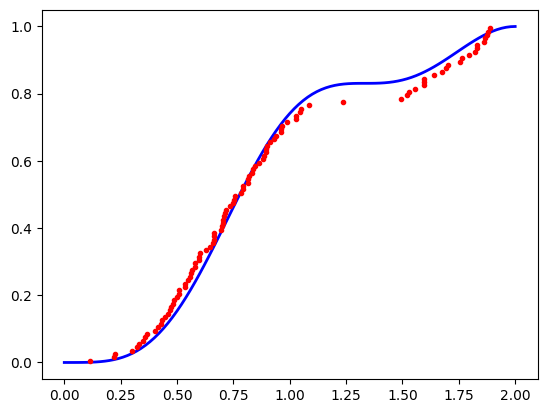

In [74]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Change of Variable

In [75]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [76]:
map_.forSym

log(x/(2 - x))

In [77]:
map_.invSym

2*exp(z)/(exp(z) + 1)

In [78]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [79]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.815842484965831, 2.836016053874601)

In [80]:
jacobSym = map_.invSym.diff(zSym).simplify().factor()
jacobSym

2*exp(z)/(exp(z) + 1)**2

In [81]:
jacobInvSym = map_.forSym.diff(xSym).simplify()
jacobInvSym

-2/(x*(x - 2))

## Maximize Log-Likelihood for Sinc Approx of P(z)

In [82]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
h = (zMax - zMin) / (nSinc - 1)

In [83]:
nSinc, h

(11, 0.5651858538840433)

In [84]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var396883)

In [85]:
logLikeP = lambda z: cp.log(sum(sv * sinc((z - sz) / h) for (sz,sv) in zip(sincZ,sincVal)))
obj = cp.Maximize(sum(logLikeP(z) for z in sampZ))

In [86]:
xSym = map_.xSym
zSym = map_.zSym

phiPrimeZSym = map_.DerivSym(1).subs(xSym, map_.invSym).simplify()
phiPrimeZSym

2*cosh(z/2)**2

In [87]:
phiPrimZ = lambdify(zSym, phiPrimeZSym)

In [88]:
constEach = list(0 <= sv for sv in sincVal)
constTotal = h * sum(sv for (sz,sv) in zip(sincZ, sincVal)) == 1
# constTotal = h * sum(sv for (sz,sv) in zip(sincZ, sincVal)) == 1
const = constEach + [constTotal]

In [89]:
prob = cp.Problem(obj,const)

In [90]:
prob.solve()

-133.61294479911538

In [91]:
sincV = list(sincVal.value)

In [92]:
sum(sincV) * h

0.9999999904026808

Text(0, 0.5, 'PDF')

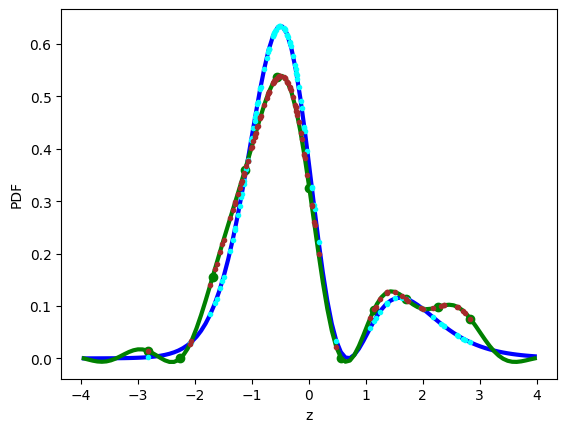

In [93]:
plot.plot(sincZ,sincV, 'o', c='green')

zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
pdf = tuple(dist.Pdf(map_.Inverse(z)) * jacobSym.subs(zSym,z) for z in zGrid)
plot.plot(zGrid,pdf, c='blue', linewidth=3)

interp = InterpZ(sincZ,sincV, zGrid)
plot.plot(zGrid,interp, c='green', linewidth=3)

sampPdf = tuple(dist.Pdf(x) * jacobSym.subs(zSym, map_.Forward(x)) for x in samp)
plot.plot(sampZ,sampPdf, '.', c='cyan')

sampEstPdf = InterpZ(sincZ,sincV, sampZ)
plot.plot(sampZ,sampEstPdf, '.', c='brown')

plot.xlabel('z')
plot.ylabel('PDF')

In [94]:
sincX = tuple(map_.Inverse(z) for z in sincZ)